In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import re
import datetime

import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy as cart
import scipy.stats as stats
import random

mpl.rcParams['figure.dpi'] = 300

In [6]:
timeseries_ds = xr.load_dataset('/Users/aedwyer/Documents/CESM_data/landuse.timeseries_0.9x1.25_hist_78pfts_CMIP6_simyr1850-2015_c190214.nc')
spatial_ds = xr.load_dataset('/Users/aedwyer/Documents/CESM_data/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1850_c190214.nc')

In [7]:
inlandfrac=np.asfarray(spatial_ds.variables["LANDFRAC_PFT"][:,:],np.float64)
inlandmask=np.asfarray(spatial_ds.variables["PFTDATA_MASK"][:,:],int)
inarea=np.asfarray(spatial_ds.variables["AREA"][:,:],np.float64)
inlandarea = inlandfrac * inarea
inlonxy = np.asfarray(spatial_ds.variables["LONGXY"][:,:],np.float64)
inlon = inlonxy[0,:]
inlatxy = np.asfarray(spatial_ds.variables["LATIXY"][:,:],np.float64)
inlat = inlatxy[:,0]
ninlat  = inlat.size
ninlon  = inlon.size
inpctglacier = np.asfarray(spatial_ds.variables["PCT_GLACIER"][:,:],np.float64)
inpctlake = np.asfarray(spatial_ds.variables["PCT_LAKE"][:,:],np.float64)
inpctwetland = np.asfarray(spatial_ds.variables["PCT_WETLAND"][:,:],np.float64)
inpcturbansub = np.asfarray(spatial_ds.variables["PCT_URBAN"][:,:,:],np.float64)
inpcturban = inpcturbansub.sum(axis=0)


inpctcrop = timeseries_ds['PCT_CROP']

In [8]:
outresults = xr.zeros_like(inpctcrop)
for yearindex in range(166):
    inpctcropyear = inpctcrop[yearindex,:,:]
    inpctnatveg = 100.0 - inpctglacier - inpctlake - inpctwetland - inpcturban - inpctcropyear
    innatvegfrac = inpctnatveg / 100.0
    outresults[yearindex] = innatvegfrac


outresults_w_coords = outresults.assign_coords(lsmlat = inlat, lsmlon = inlon)

Text(0, 0.5, 'Total Vegetation (%)')

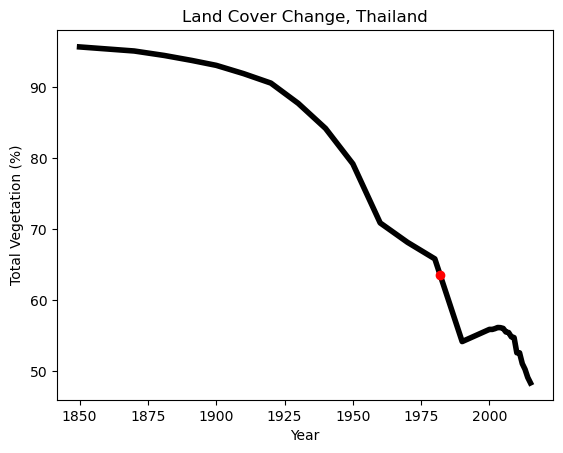

In [153]:
lat = 13.44
lon = 101.98
year_sel = 1982
(outresults_w_coords * 100).sel(lsmlat = lat, lsmlon = lon, method = 'nearest').plot(linewidth = 4, color = 'black')
dot_value = (outresults_w_coords * 100).sel(lsmlat = lat, lsmlon = lon, method = 'nearest').sel(time=year_sel)  # Extract the value at the year year_sel
plt.plot(year_sel, dot_value, 'ro')  # 'ro' stands for red dot
plt.title('Land Cover Change, Thailand')
plt.xlabel('Year')
plt.ylabel('Total Vegetation (%)')

Text(0.5, 1.0, 'Change in Natural Vegetation 1850-1975')

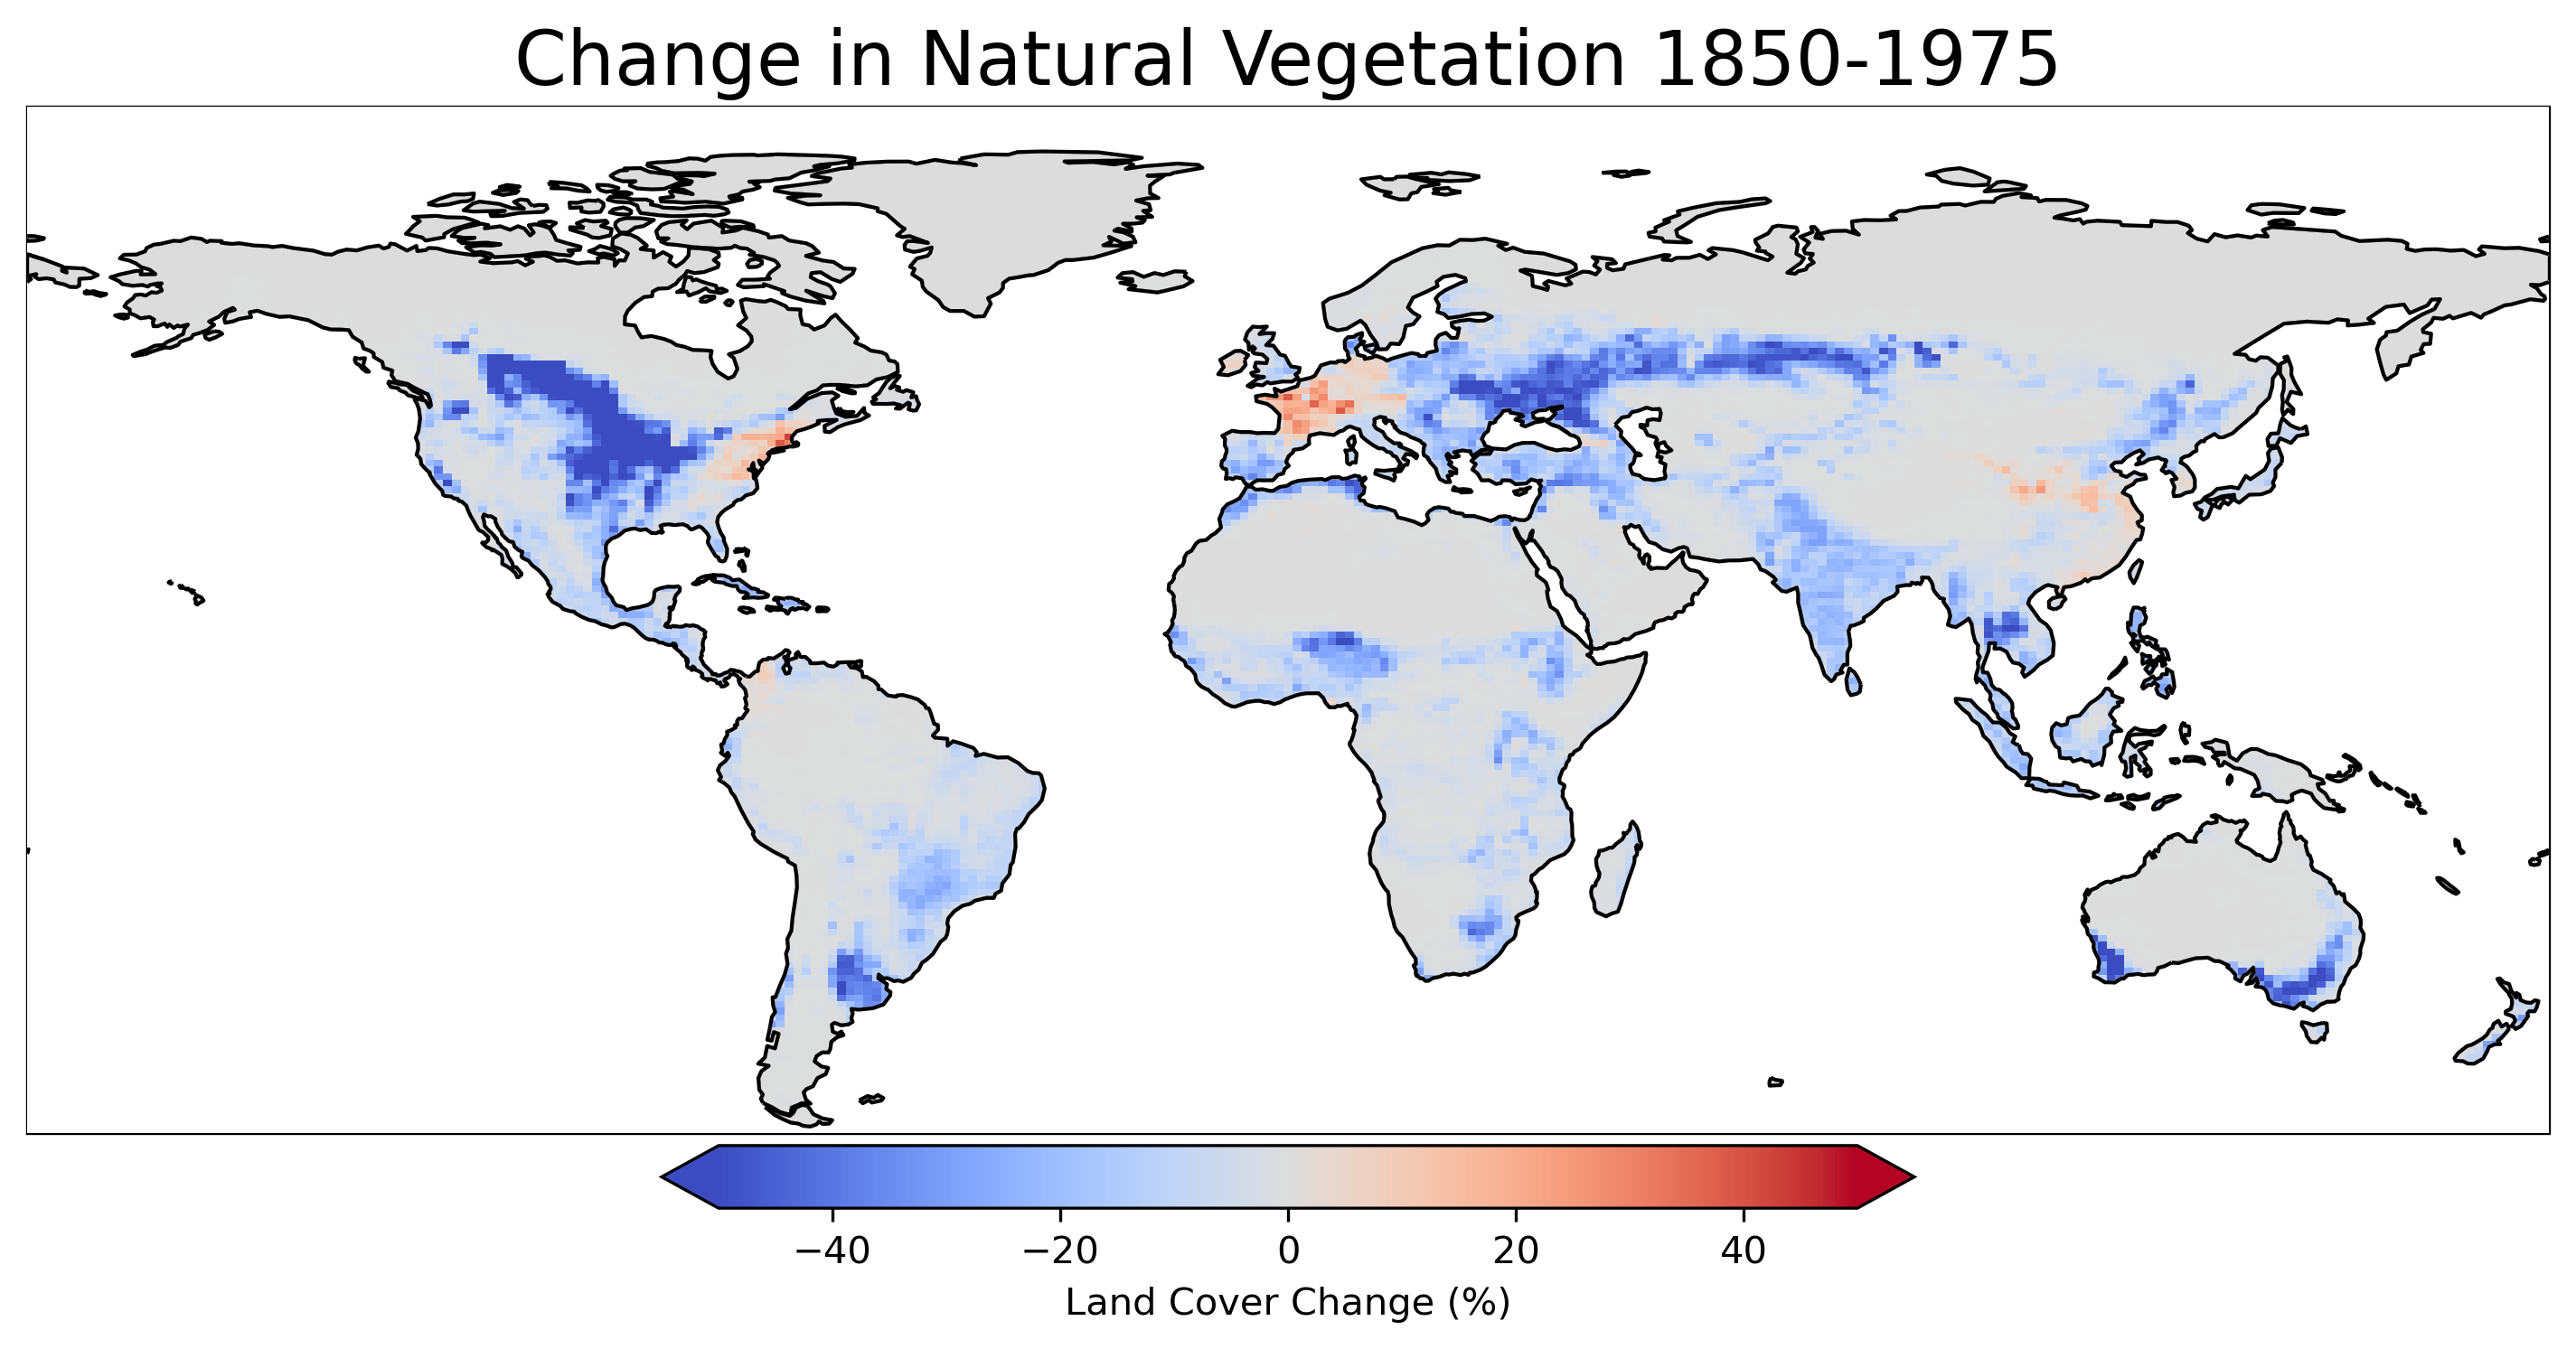

In [9]:
# Apply latitude bounds to exclude Antarctica
lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
final_results =(outresults_w_coords * 100).where(outresults_w_coords['lsmlat'] > lat_bounds, drop=True)

# Extract the filtered latitude and longitude values
lon = final_results['lsmlon']
lat = final_results['lsmlat']

plt.figure(figsize=(12,6))
ax = plt.axes(projection = ccrs.PlateCarree()) 
plt.pcolormesh(lon, lat, final_results.sel(time = 1975) - final_results.sel(time = 1850), cmap = 'coolwarm', transform = ccrs.PlateCarree(), vmin = -50, vmax = 50)

#plt.plot(360-51.63, -21.5, transform = ccrs.PlateCarree(), marker = 's', color = 'black', zorder = 101, markersize = 8, markerfacecolor = 'none')

cbar = plt.colorbar(label = 'Land Cover Change (%)', orientation = 'horizontal', extend = 'both', fraction = 0.05, pad = 0.01)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cfeature.COASTLINE, zorder = 101, edgecolor = 'black')
plt.title(f"Change in Natural Vegetation 1850-1975", size = 20)

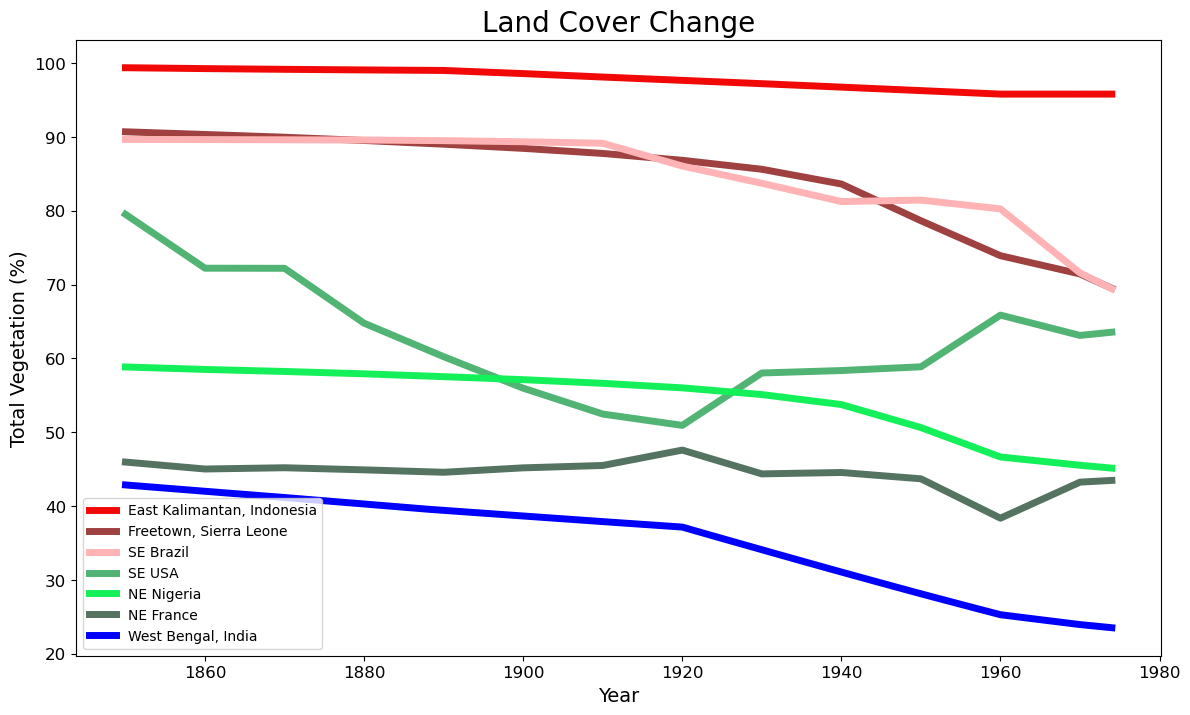

In [214]:
coordinates = [ (-0.54, 114.02), (8.49, 13.24), (-20.72, 360 - 51.63), (35.33, 360 - 88.19), (12.29, 13.93), (48.19,2.99), (23.67, 87.80) ]
labels = ['East Kalimantan, Indonesia', 'Freetown, Sierra Leone', 'SE Brazil', 'SE USA', 'NE Nigeria', 'NE France',  'West Bengal, India']
colors = ['#F00907', '#9F4140', '#FFB3B4', '#51B374', '#14F05A', '#557361', 'blue',]

plt.figure(figsize=(14,8))
i = 0
for lat_c, lon_c in coordinates:
    (outresults_w_coords[:125] * 100).sel(lsmlat = lat_c, lsmlon = lon_c, method = 'nearest').plot(linewidth = 5, color = colors[i], label = labels[i])
    i += 1

plt.title('Land Cover Change', size = 20)
plt.xlabel('Year', size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel('Total Vegetation (%)', size = 14)
plt.legend()

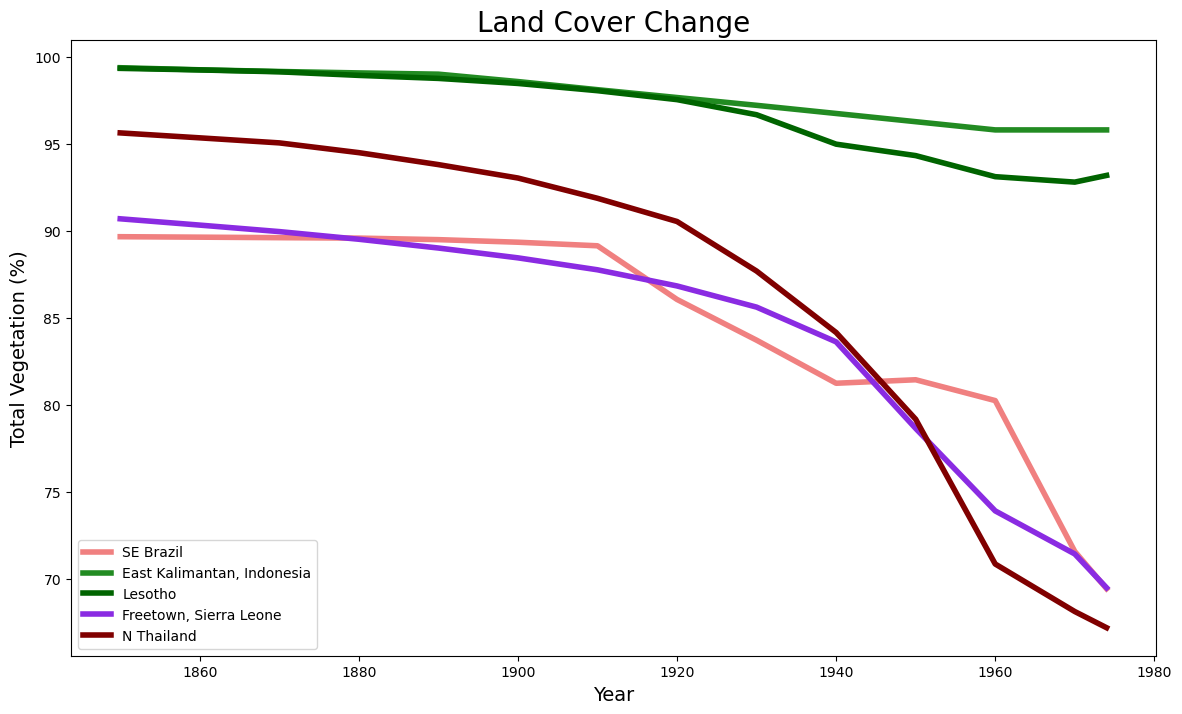

In [195]:
coordinates = [(-20.72, 360 - 51.63), (-0.54, 114.02), (-29.27,28.22), (8.49, 13.24), (13.44, 101.98)]
labels = ['SE Brazil', 'East Kalimantan, Indonesia', 'Lesotho', 'Freetown, Sierra Leone', 'N Thailand']
colors = ['lightcoral', 'forestgreen', 'darkgreen', 'blueviolet', 'maroon', 'aquamarine', 'tomato', 'red', 'firebrick']

plt.figure(figsize=(14,8))
i = 0
for lat_c, lon_c in coordinates:
    (outresults_w_coords[:125] * 100).sel(lsmlat = lat_c, lsmlon = lon_c, method = 'nearest').plot(linewidth = 4, color = colors[i], label = labels[i])
    i += 1

plt.title('Land Cover Change', size = 20)
plt.xlabel('Year', size = 14)
plt.ylabel('Total Vegetation (%)', size = 14)
plt.legend()

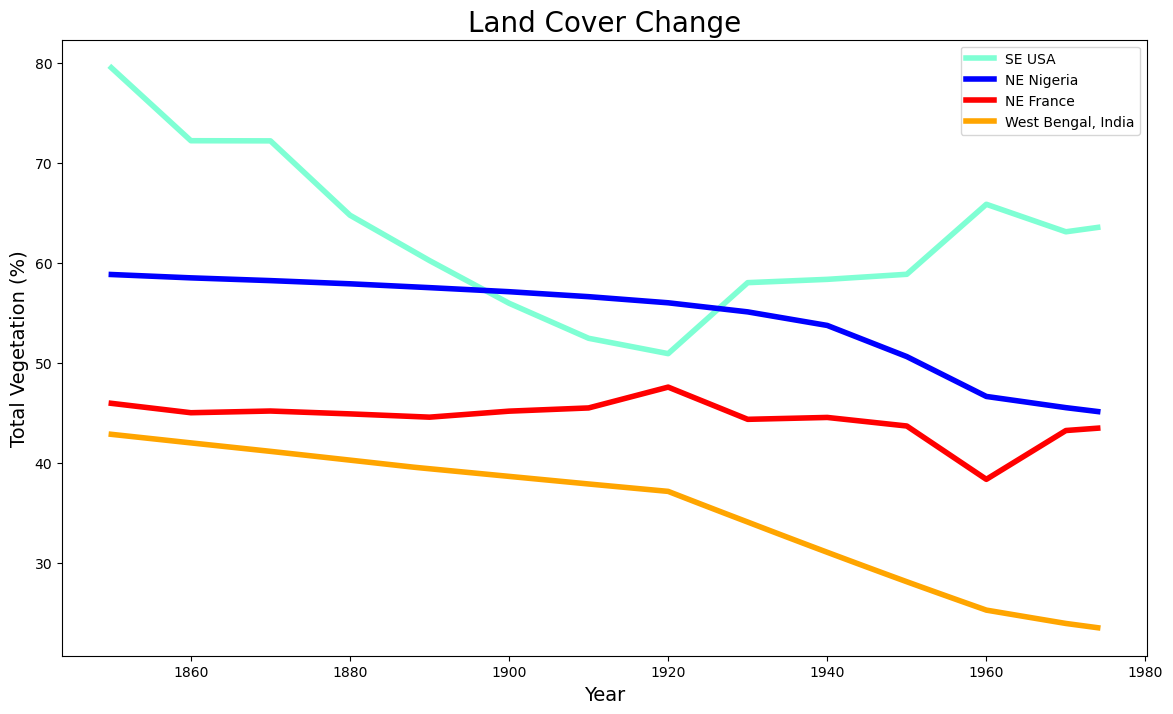

In [202]:
coordinates = [(35.33, 360 - 88.19), (12.29, 13.93), (48.19,2.99), (23.67, 87.80)]
labels = ['SE USA', 'NE Nigeria', 'NE France', 'West Bengal, India']
colors = [ 'aquamarine', 'blue', 'red', 'orange']

plt.figure(figsize=(14,8))
i = 0
for lat_c, lon_c in coordinates:
    (outresults_w_coords[:125] * 100).sel(lsmlat = lat_c, lsmlon = lon_c, method = 'nearest').plot(linewidth = 4, color = colors[i], label = labels[i])
    i += 1

plt.title('Land Cover Change', size = 20)
plt.xlabel('Year', size = 14)
plt.ylabel('Total Vegetation (%)', size = 14)
plt.legend()

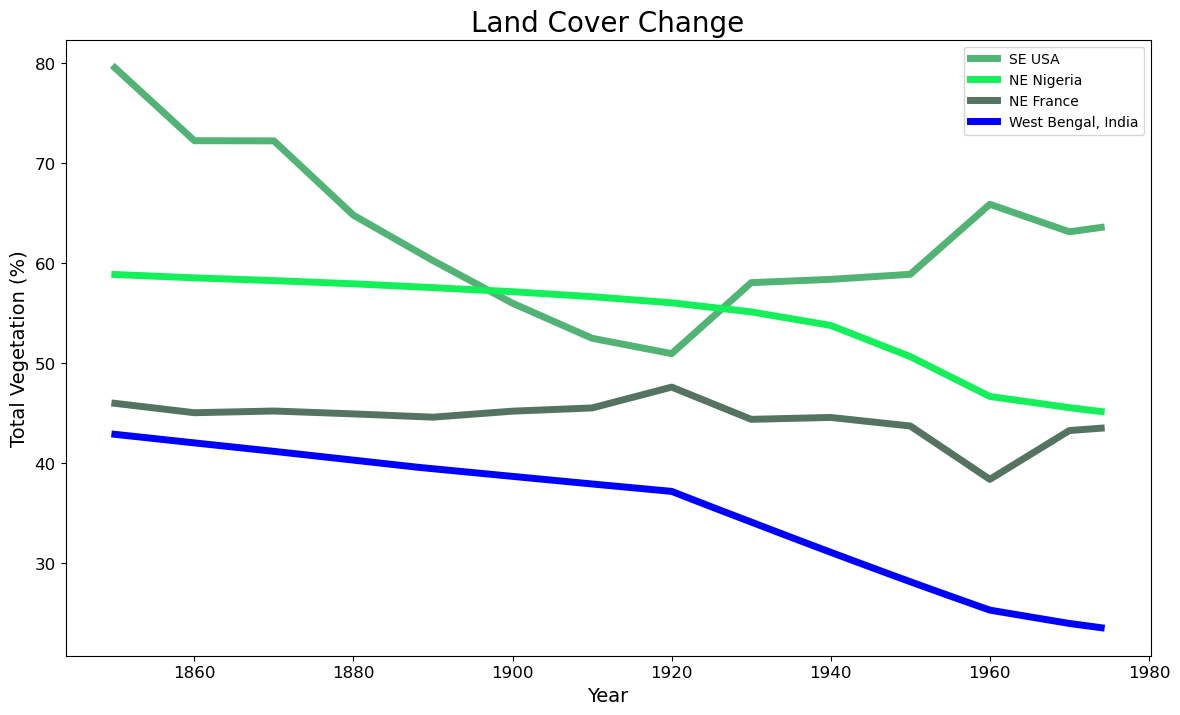

In [216]:
coordinates = [ (35.33, 360 - 88.19), (12.29, 13.93), (48.19,2.99), (23.67, 87.80) ]
labels = [ 'SE USA', 'NE Nigeria', 'NE France',  'West Bengal, India']
colors = ['#51B374', '#14F05A', '#557361', 'blue',]

plt.figure(figsize=(14,8))
i = 0
for lat_c, lon_c in coordinates:
    (outresults_w_coords[:125] * 100).sel(lsmlat = lat_c, lsmlon = lon_c, method = 'nearest').plot(linewidth = 5, color = colors[i], label = labels[i])
    i += 1

plt.title('Land Cover Change', size = 20)
plt.xlabel('Year', size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel('Total Vegetation (%)', size = 14)
plt.legend()